# Part 3 analysis code:

Written by Tien Dao for 3.2 and 3.3 of Part 3.

In [40]:
import os, sys
import re
import regex
import time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter


In [41]:
sys.path.append(os.path.abspath("part1"))
sys.path.append(os.path.abspath("part2"))

DATA_DIR = os.path.abspath("data")
SENTIMENT_PATH = os.path.join(DATA_DIR, "sentiment140_noemoticon_10000.csv")
WIKI_PATH = os.path.join(DATA_DIR, "simple_english_wikipedia_10000.txt")

print("Data dir:", DATA_DIR)
print("Sentiment file exists?", os.path.exists(SENTIMENT_PATH))
print("Wiki file exists?", os.path.exists(WIKI_PATH))

from part1.hw1_part1 import preprocess_part1  # Part 1 pipeline :contentReference[oaicite:5]{index=5}
from part2.bpe import BPE_Tokenizer           # Base BPE :contentReference[oaicite:6]{index=6}
from part2.sentencePiece_bpe import SentencePieceBPE  # SentencePiece variant :contentReference[oaicite:7]{index=7}

Data dir: /home/tiendao2008/nlp_hw1/data
Sentiment file exists? True
Wiki file exists? True


2. Compare base BPE (Part 2.2) with and without using the regex pre-processing steps from Part 1 on
the sentiment140 dataset.

In [42]:
# Load dataset
def load_sentiment140(path):
    texts = []
    with open(path, "r", encoding="latin-1", newline="") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue
            texts.append(str(row[-1]))
    return texts

def load_wikipedia(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        texts = [line.strip("\n") for line in f]
    # drop empty lines
    texts = [t for t in texts if t.strip()]
    return texts

sent_texts = load_sentiment140(SENTIMENT_PATH)
wiki_texts = load_wikipedia(WIKI_PATH)

print("Sentiment140 samples:", len(sent_texts))
print("Wikipedia samples:", len(wiki_texts))
print("\nExample sentiment:", sent_texts[0][:120])
print("Example wiki:", wiki_texts[0][:120])

Sentiment140 samples: 10000
Wikipedia samples: 4833

Example sentiment: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Example wiki: April


In [43]:
# Helper functions for stats and plotting
def basic_stats(per_line_counts, all_ids):
    arr = np.array(per_line_counts, dtype=float)
    total = int(arr.sum())
    uniq = len(set(all_ids)) if all_ids else 0
    return {
        "lines": len(per_line_counts),
        "avg_tokens_per_line": float(arr.mean()) if len(arr) else 0.0,
        "median_tokens_per_line": float(np.median(arr)) if len(arr) else 0.0,
        "p90_tokens_per_line": float(np.percentile(arr, 90)) if len(arr) else 0.0,
        "total_tokens": total,
        "unique_token_types_used": uniq,
        "type_token_ratio": (uniq / total) if total > 0 else 0.0,
    }

def print_summary(name, tok, train_time_s, stats):
    vs = getattr(tok, "vocab_size", None)
    print(f"\n=== {name} ===")
    print("vocab_size:", vs)
    print("train_time_sec:", round(train_time_s, 3))
    for k, v in stats.items():
        print(f"{k}: {v}")

def encode_counts_and_ids(tok, texts):
    per_line = []
    all_ids = []
    for t in texts:
        ids = tok.encode(t)
        per_line.append(len(ids))
        all_ids.extend(ids)
    return per_line, all_ids

In [44]:
def token_freq_top_bottom(all_ids, top_k=100):
    c = Counter(all_ids)
    top = c.most_common(top_k)
    bottom = sorted(c.items(), key=lambda x: x[1])[:top_k]
    return top, bottom

def pretty_print_token_freqs(title, freq_list, tok=None, max_show=20):
    """
    freq_list: list[(token_id, count)]
    tok: optional tokenizer to decode token ids to bytes/strings if possible
    """
    print(f"\n{title} (showing {min(max_show, len(freq_list))} of {len(freq_list)})")
    for tid, cnt in freq_list[:max_show]:
        s = None
        if tok is not None and hasattr(tok, "id_to_bytes") and tid in tok.id_to_bytes:
            # decode bytes for display
            try:
                s = tok.id_to_bytes[tid].decode("utf-8", errors="replace")
            except Exception:
                s = str(tok.id_to_bytes[tid])
        if s is None:
            print(f"  id={tid:>5}  count={cnt}")
        else:
            print(f"  id={tid:>5}  count={cnt:<6} token={repr(s)}")

In [45]:
def longest_subwords(tok, top_k=100):
    """
    Returns the longest learned subwords based on decoded string length.
    Uses tok.id_to_bytes if available.
    """
    if not hasattr(tok, "id_to_bytes"):
        print("Tokenizer has no id_to_bytes; cannot list subwords.")
        return []

    items = []
    for tid, b in tok.id_to_bytes.items():
        if not isinstance(b, (bytes, bytearray)):
            continue
        s = b.decode("utf-8", errors="replace")
        items.append((len(s), tid, s))
    items.sort(reverse=True, key=lambda x: x[0])
    return items[:top_k]

def print_longest_subwords(tok, title, top_k=20):
    L = longest_subwords(tok, top_k=top_k)
    print(f"\n{title}: Longest {top_k} subwords")
    for length, tid, s in L:
        print(f"  len={length:<3} id={tid:<6} subword={repr(s)}")

In [46]:
NUM_MERGES = 1000 

# --- Train corpora ---
sent_train_raw = "\n".join(sent_texts)
sent_train_pp  = "\n".join(preprocess_part1(t) for t in sent_texts)

# --- Eval texts ---
sent_eval_raw = sent_texts
sent_eval_pp  = [preprocess_part1(t) for t in sent_texts]

# --- Train raw ---
bpe_raw = BPE_Tokenizer()
t0 = time.time()
bpe_raw.train(sent_train_raw, num_merges=NUM_MERGES)
t_raw = time.time() - t0

Start training with 21570 unique words...
Merge 1: (32, 116) -> 256 (b' t')
Merge 2: (105, 110) -> 257 (b'in')
Merge 3: (32, 97) -> 258 (b' a')
Merge 4: (32, 115) -> 259 (b' s')
Merge 5: (104, 101) -> 260 (b'he')
Merge 6: (32, 119) -> 261 (b' w')
Merge 7: (32, 109) -> 262 (b' m')
Merge 8: (257, 103) -> 263 (b'ing')
Merge 9: (32, 105) -> 264 (b' i')
Merge 10: (114, 101) -> 265 (b're')
Merge 11: (32, 98) -> 266 (b' b')
Merge 12: (111, 110) -> 267 (b'on')
Merge 13: (256, 111) -> 268 (b' to')
Merge 14: (46, 46) -> 269 (b'..')
Merge 15: (104, 97) -> 270 (b'ha')
Merge 16: (111, 117) -> 271 (b'ou')
Merge 17: (111, 114) -> 272 (b'or')
Merge 18: (32, 73) -> 273 (b' I')
Merge 19: (32, 102) -> 274 (b' f')
Merge 20: (101, 114) -> 275 (b'er')
Merge 21: (32, 100) -> 276 (b' d')
Merge 22: (32, 99) -> 277 (b' c')
Merge 23: (256, 260) -> 278 (b' the')
Merge 24: (108, 108) -> 279 (b'll')
Merge 25: (32, 110) -> 280 (b' n')
Merge 26: (32, 103) -> 281 (b' g')
Merge 27: (97, 110) -> 282 (b'an')
Merge 28: (1

In [47]:
raw_counts, raw_ids = encode_counts_and_ids(bpe_raw, sent_eval_raw)
raw_stats = basic_stats(raw_counts, raw_ids)
print_summary("3.2 Sentiment140 Base BPE (raw)", bpe_raw, t_raw, raw_stats)

raw_top, raw_bottom = token_freq_top_bottom(raw_ids, top_k=100)
pretty_print_token_freqs("RAW Top 100 tokens", raw_top, tok=bpe_raw, max_show=20)
pretty_print_token_freqs("RAW Bottom 100 tokens", raw_bottom, tok=bpe_raw, max_show=20)
print_longest_subwords(bpe_raw, "RAW", top_k=20)


=== 3.2 Sentiment140 Base BPE (raw) ===
vocab_size: 1256
train_time_sec: 24.986
lines: 10000
avg_tokens_per_line: 28.8458
median_tokens_per_line: 27.0
p90_tokens_per_line: 49.0
total_tokens: 288458
unique_token_types_used: 1097
type_token_ratio: 0.0038029799832211275

RAW Top 100 tokens (showing 20 of 100)
  id=   32  count=11179  token=' '
  id=   46  count=6032   token='.'
  id=  268  count=4276   token=' to'
  id=  273  count=4258   token=' I'
  id=  115  count=4209   token='s'
  id=   64  count=3423   token='@'
  id=   44  count=3090   token=','
  id=  278  count=3051   token=' the'
  id=  258  count=2745   token=' a'
  id=  263  count=2456   token='ing'
  id=  121  count=2387   token='y'
  id=   33  count=2158   token='!'
  id=  296  count=1986   token='ed'
  id=  304  count=1973   token=' my'
  id=  264  count=1948   token=' i'
  id=  307  count=1860   token=' in'
  id=  309  count=1824   token=' and'
  id=  306  count=1722   token=' it'
  id=  105  count=1689   token='i'
  id= 

In [48]:
NUM_MERGES = 1000  # per HW

# --- Train corpora ---
sent_train_raw = "\n".join(sent_texts)
sent_train_pp  = "\n".join(preprocess_part1(t) for t in sent_texts)

# --- Eval texts ---
sent_eval_raw = sent_texts
sent_eval_pp  = [preprocess_part1(t) for t in sent_texts]

# --- Train raw ---
bpe_raw = BPE_Tokenizer()
t0 = time.time()
bpe_raw.train(sent_train_raw, num_merges=NUM_MERGES)
t_raw = time.time() - t0

raw_counts, raw_ids = encode_counts_and_ids(bpe_raw, sent_eval_raw)
raw_stats = basic_stats(raw_counts, raw_ids)
print_summary("3.2 Sentiment140 Base BPE (raw)", bpe_raw, t_raw, raw_stats)

raw_top, raw_bottom = token_freq_top_bottom(raw_ids, top_k=100)
pretty_print_token_freqs("RAW Top 100 tokens", raw_top, tok=bpe_raw, max_show=20)
pretty_print_token_freqs("RAW Bottom 100 tokens", raw_bottom, tok=bpe_raw, max_show=20)
print_longest_subwords(bpe_raw, "RAW", top_k=20)

Start training with 21570 unique words...
Merge 1: (32, 116) -> 256 (b' t')
Merge 2: (105, 110) -> 257 (b'in')
Merge 3: (32, 97) -> 258 (b' a')
Merge 4: (32, 115) -> 259 (b' s')
Merge 5: (104, 101) -> 260 (b'he')
Merge 6: (32, 119) -> 261 (b' w')
Merge 7: (32, 109) -> 262 (b' m')
Merge 8: (257, 103) -> 263 (b'ing')
Merge 9: (32, 105) -> 264 (b' i')
Merge 10: (114, 101) -> 265 (b're')
Merge 11: (32, 98) -> 266 (b' b')
Merge 12: (111, 110) -> 267 (b'on')
Merge 13: (256, 111) -> 268 (b' to')
Merge 14: (46, 46) -> 269 (b'..')
Merge 15: (104, 97) -> 270 (b'ha')
Merge 16: (111, 117) -> 271 (b'ou')
Merge 17: (111, 114) -> 272 (b'or')
Merge 18: (32, 73) -> 273 (b' I')
Merge 19: (32, 102) -> 274 (b' f')
Merge 20: (101, 114) -> 275 (b'er')
Merge 21: (32, 100) -> 276 (b' d')
Merge 22: (32, 99) -> 277 (b' c')
Merge 23: (256, 260) -> 278 (b' the')
Merge 24: (108, 108) -> 279 (b'll')
Merge 25: (32, 110) -> 280 (b' n')
Merge 26: (32, 103) -> 281 (b' g')
Merge 27: (97, 110) -> 282 (b'an')
Merge 28: (1

In [ ]:
# --- Train preprocessed ---
bpe_pp = BPE_Tokenizer()
t0 = time.time()
bpe_pp.train(sent_train_pp, num_merges=NUM_MERGES)
t_pp = time.time() - t0

Start training with 17557 unique words...
Merge 1: (32, 116) -> 256 (b' t')
Merge 2: (105, 110) -> 257 (b'in')
Merge 3: (32, 97) -> 258 (b' a')
Merge 4: (32, 115) -> 259 (b' s')
Merge 5: (104, 101) -> 260 (b'he')
Merge 6: (32, 119) -> 261 (b' w')
Merge 7: (32, 109) -> 262 (b' m')
Merge 8: (32, 105) -> 263 (b' i')
Merge 9: (257, 103) -> 264 (b'ing')
Merge 10: (32, 98) -> 265 (b' b')
Merge 11: (256, 111) -> 266 (b' to')
Merge 12: (111, 114) -> 267 (b'or')
Merge 13: (46, 46) -> 268 (b'..')
Merge 14: (111, 110) -> 269 (b'on')
Merge 15: (111, 117) -> 270 (b'ou')
Merge 16: (104, 97) -> 271 (b'ha')
Merge 17: (114, 101) -> 272 (b're')
Merge 18: (32, 73) -> 273 (b' I')
Merge 19: (32, 102) -> 274 (b' f')
Merge 20: (32, 100) -> 275 (b' d')
Merge 21: (101, 114) -> 276 (b'er')
Merge 22: (32, 99) -> 277 (b' c')
Merge 23: (256, 260) -> 278 (b' the')
Merge 24: (32, 110) -> 279 (b' n')
Merge 25: (108, 108) -> 280 (b'll')
Merge 26: (79, 78) -> 281 (b'ON')
Merge 27: (32, 103) -> 282 (b' g')
Merge 28: (77

In [ ]:
pp_counts, pp_ids = encode_counts_and_ids(bpe_pp, sent_eval_pp)
pp_stats = basic_stats(pp_counts, pp_ids)
print_summary("3.2 Sentiment140 Base BPE (preprocessed)", bpe_pp, t_pp, pp_stats)

pp_top, pp_bottom = token_freq_top_bottom(pp_ids, top_k=100)
pretty_print_token_freqs("PP Top 100 tokens", pp_top, tok=bpe_pp, max_show=20)
pretty_print_token_freqs("PP Bottom 100 tokens", pp_bottom, tok=bpe_pp, max_show=20)
print_longest_subwords(bpe_pp, "PP", top_k=20)

In [ ]:
# Plot helper functions
def plot_hist(ax, counts, title, bins=60):
    ax.hist(counts, bins=bins)
    ax.set_title(title)
    ax.set_xlabel("Tokens per line")
    ax.set_ylabel("Count")

def plot_box(ax, counts_dict, title):
    labels = list(counts_dict.keys())
    data = [counts_dict[k] for k in labels]
    ax.boxplot(data, labels=labels, showfliers=False)
    ax.set_title(title)
    ax.set_ylabel("Tokens per line")
    ax.tick_params(axis="x", rotation=15)

def plot_cdf(ax, counts_dict, title):
    for label, counts in counts_dict.items():
        x = np.sort(np.array(counts))
        y = np.arange(1, len(x) + 1) / len(x)
        ax.plot(x, y, label=label)
    ax.set_title(title)
    ax.set_xlabel("Tokens per line")
    ax.set_ylabel("CDF")
    ax.legend()

/tmp/ipykernel_201638/3687686294.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False)


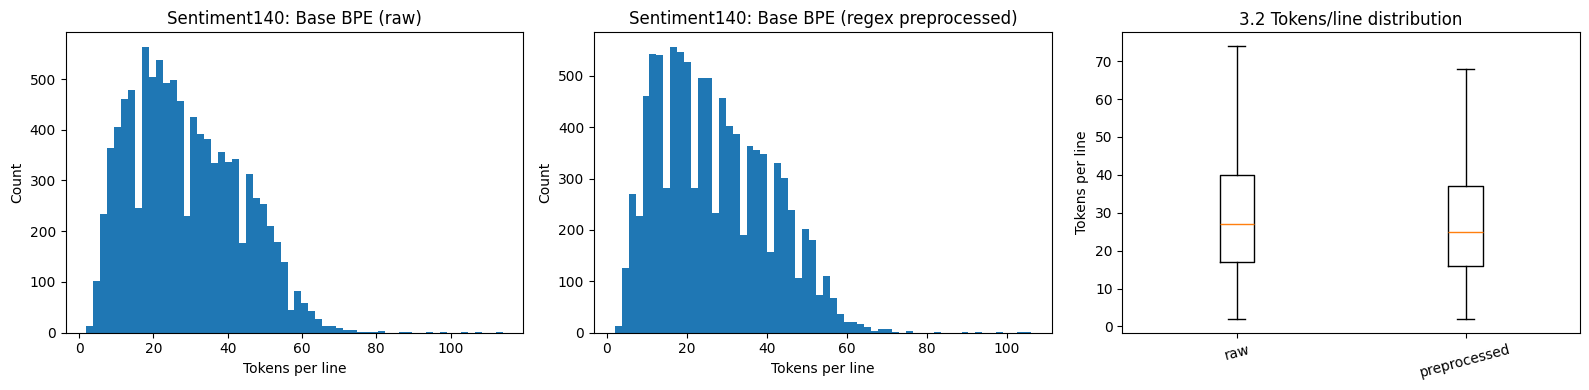

In [51]:
# Base BPE raw vs preprocessed stats
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_hist(axes[0], raw_counts, "Sentiment140: Base BPE (raw)")
plot_hist(axes[1], pp_counts,  "Sentiment140: Base BPE (regex preprocessed)")
plot_box(axes[2], {"raw": raw_counts, "preprocessed": pp_counts}, "3.2 Tokens/line distribution")
plt.tight_layout()
plt.show()

3.  Compare base BPE (Part 2.2) and SentencePiece (Part 2.3) on both datasets. You may include preprocessing steps from Part 1 if deemed appropriate based on analyses of prior steps.

In [52]:
# Base BPE vs SentencePiece on both datasets
# Sentiment (preprocessed)
sp_sent = SentencePieceBPE()
sp_sent.train("\n".join(preprocess_part1(t) for t in sent_texts), num_merges=NUM_MERGES)

bpe_sent = BPE_Tokenizer()
bpe_sent.train("\n".join(preprocess_part1(t) for t in sent_texts), num_merges=NUM_MERGES)

bpe_sent_counts = [len(bpe_sent.encode(preprocess_part1(t))) for t in sent_texts]
sp_sent_counts  = [len(sp_sent.encode(preprocess_part1(t)))  for t in sent_texts]

# Wiki (raw)
sp_wiki = SentencePieceBPE()
sp_wiki.train("\n".join(wiki_texts), num_merges=NUM_MERGES)

bpe_wiki = BPE_Tokenizer()
bpe_wiki.train("\n".join(wiki_texts), num_merges=NUM_MERGES)

bpe_wiki_counts = [len(bpe_wiki.encode(t)) for t in wiki_texts]
sp_wiki_counts  = [len(sp_wiki.encode(t))  for t in wiki_texts]


Training on 9949 unique sentences/lines...
Merge 1: (101, 32) -> 256 (b'e ')
Merge 2: (116, 32) -> 257 (b't ')
Merge 3: (32, 116) -> 258 (b' t')
Merge 4: (105, 110) -> 259 (b'in')
Merge 5: (115, 32) -> 260 (b's ')
Merge 6: (121, 32) -> 261 (b'y ')
Merge 7: (100, 32) -> 262 (b'd ')
Merge 8: (111, 32) -> 263 (b'o ')
Merge 9: (46, 32) -> 264 (b'. ')
Merge 10: (97, 110) -> 265 (b'an')
Merge 11: (259, 103) -> 266 (b'ing')
Merge 12: (101, 114) -> 267 (b'er')
Merge 13: (111, 114) -> 268 (b'or')
Merge 14: (111, 110) -> 269 (b'on')
Merge 15: (258, 104) -> 270 (b' th')
Merge 16: (111, 117) -> 271 (b'ou')
Merge 17: (266, 32) -> 272 (b'ing ')
Merge 18: (116, 104) -> 273 (b'th')
Merge 19: (46, 46) -> 274 (b'..')
Merge 20: (108, 108) -> 275 (b'll')
Merge 21: (79, 78) -> 276 (b'ON')
Merge 22: (77, 69) -> 277 (b'ME')
Merge 23: (93, 32) -> 278 (b'] ')
Merge 24: (84, 73) -> 279 (b'TI')
Merge 25: (279, 276) -> 280 (b'TION')
Merge 26: (277, 78) -> 281 (b'MEN')
Merge 27: (91, 281) -> 282 (b'[MEN')
Merge 28

KeyboardInterrupt: 

In [ ]:
# Plot
fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax[0,0].hist(bpe_sent_counts, bins=60); ax[0,0].set_title("Sentiment: Base BPE")
ax[0,1].hist(sp_sent_counts,  bins=60); ax[0,1].set_title("Sentiment: SentencePiece")
ax[1,0].hist(bpe_wiki_counts, bins=60); ax[1,0].set_title("Wiki: Base BPE")
ax[1,1].hist(sp_wiki_counts,  bins=60); ax[1,1].set_title("Wiki: SentencePiece")
for a in ax.ravel():
    a.set_xlabel("tokens/line"); a.set_ylabel("count")

plt.tight_layout(); plt.show()